# 训练LGB模型

In [1]:
#首先 import 必要的模块
import pandas as pd
import numpy as np

import lightgbm as lgbm
from lightgbm.sklearn import LGBMClassifier

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

## 读取数据

In [3]:
# 数据路径
dpath = './data/FE/'

# 数据名称
train_file = 'train_FE.csv'

train = pd.read_csv(dpath + train_file)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Columns: 472 entries, user_id to amt_labels
dtypes: float64(23), int64(443), object(6)
memory usage: 3.5+ GB


In [5]:
# 数据名称
tag_file = 'my_user_taglist_embedding_16.csv'

tag_df = pd.read_csv(dpath + tag_file, parse_dates=['tag_insert_date'])

In [6]:
tag_df.head()

,user_id,tag_insert_date,user_tag_em0,user_tag_em1,user_tag_em2,user_tag_em3,user_tag_em4,user_tag_em5,user_tag_em6,user_tag_em7,user_tag_em8,user_tag_em9,user_tag_em10,user_tag_em11,user_tag_em12,user_tag_em13,user_tag_em14,user_tag_em15
0,847942,2019-03-30,-0.009541,0.046927,0.150124,0.067106,-0.053549,-0.052527,-0.118447,-0.189506,0.047880,0.045362,0.005770,0.047658,0.076804,0.092214,-0.036028,-0.013745
1,13643,2019-03-30,-0.128934,-0.199308,0.050897,-0.031567,0.035126,0.102144,0.116876,-0.174700,0.137516,-0.054134,0.332327,0.098563,0.186932,-0.046062,-0.077789,0.089081
2,740882,2019-03-30,0.014962,-0.068173,0.080191,0.037246,0.153650,0.041137,-0.073232,-0.168886,0.130458,0.115955,0.087409,-0.095562,0.192777,0.137690,-0.172390,-0.178010
3,905326,2019-03-30,-0.056296,-0.154246,-0.035075,0.024448,-0.136231,-0.172483,-0.298507,0.035442,-0.029554,0.036552,0.324608,0.018503,0.026310,0.328730,-0.097493,0.015569
4,411367,2019-03-30,-0.019651,-0.119835,0.007948,0.046666,0.018225,-0.120978,0.045126,-0.032201,0.119008,0.030255,-0.025160,0.045501,-0.004733,0.066168,-0.091798,-0.056811


In [7]:
behavior_file = 'new_user_behavior.csv'
behavior_df = pd.read_csv(dpath + behavior_file)

In [8]:
behavior_df.head()

,user_id,sum,behaviro_type1,behaviro_type2,behaviro_type3
0,1,28,13.0,NaN,15.0
1,3,47,46.0,NaN,1.0
2,4,8,8.0,NaN,NaN
3,5,25,15.0,NaN,10.0
4,6,86,86.0,NaN,NaN


In [9]:
behavior_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920161 entries, 0 to 920160
Data columns (total 5 columns):
user_id           920161 non-null int64
sum               920161 non-null int64
behaviro_type1    920107 non-null float64
behaviro_type2    389360 non-null float64
behaviro_type3    672720 non-null float64
dtypes: float64(3), int64(2)
memory usage: 35.1 MB


## 准备数据

### 更改数据类型

In [10]:
# # 设置日期型数据类型
# date_cols = ['auditing_date', 'due_date', 'reg_mon', 'info_insert_date', 'tag_insert_date']
# for col in date_cols:
#     train[col] = pd.to_datetime(train[col])

# # 将独热的数据类型改为uint8节省内存方便计算
# oh_names = pd.read_csv(dpath + 'onehot_names.csv')
# for col in oh_names.values:
#     train[col] = train[col].astype('uint8')

# 将独热的数据删除
oh_names = pd.read_csv(dpath + 'onehot_names.csv')
del_oh_names = []
for index, row in oh_names.iterrows():
    del_oh_names.append(row['oh_name'])
train = train.drop(del_oh_names, axis=1)
train.head()
# train.columns

,user_id,listing_id,auditing_date,due_date,due_amt,term,rate,principal,reg_mon,gender,...,info_insert_date_year,info_insert_date_month,info_insert_date_day,info_insert_date_dayofweek,tag_insert_date_year,tag_insert_date_month,tag_insert_date_day,tag_insert_date_dayofweek,clf_label,amt_labels
0,748147,3163926,2018-04-25,2018-05-25,72.1167,9,7.2,630,2017-12-01,0,...,2018,4,24,1,2018.0,11.0,12.0,0.0,0,72.1167
1,672952,3698760,2018-06-09,2018-07-09,258.7045,9,7.2,2260,2017-09-01,0,...,2018,6,4,0,2018.0,6.0,4.0,0.0,1,258.7045
2,404196,2355665,2018-02-18,2018-03-18,307.9270,9,7.2,2690,2017-02-01,0,...,2018,2,17,5,2018.0,2.0,17.0,5.0,-1,0.0000
3,342769,1994522,2018-01-13,2018-02-13,252.9809,9,7.2,2210,2016-12-01,0,...,2018,1,12,4,2018.0,1.0,12.0,4.0,0,252.9809
4,828139,3602352,2018-06-01,2018-07-01,107.6503,6,8.6,630,2018-04-01,0,...,2018,5,31,3,2018.0,5.0,31.0,3.0,6,107.6503


In [11]:
train = train.merge(tag_df, on='user_id', how='left')

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 68 columns):
user_id                       1000000 non-null int64
listing_id                    1000000 non-null int64
auditing_date                 1000000 non-null object
due_date                      1000000 non-null object
due_amt                       1000000 non-null float64
term                          1000000 non-null int64
rate                          1000000 non-null float64
principal                     1000000 non-null int64
reg_mon                       1000000 non-null object
gender                        1000000 non-null int64
age                           1000000 non-null int64
cell_province                 1000000 non-null int64
id_province                   1000000 non-null int64
id_city                       1000000 non-null int64
info_insert_date              1000000 non-null object
taglist                       574469 non-null object
tag_insert_date_x             57

In [13]:
train = train.merge(behavior_df, on='user_id', how='left')

In [14]:
train.head()

,user_id,listing_id,auditing_date,due_date,due_amt,term,rate,principal,reg_mon,gender,...,user_tag_em10,user_tag_em11,user_tag_em12,user_tag_em13,user_tag_em14,user_tag_em15,sum,behaviro_type1,behaviro_type2,behaviro_type3
0,748147,3163926,2018-04-25,2018-05-25,72.1167,9,7.2,630,2017-12-01,0,...,0.226255,0.019565,0.103824,0.027327,-0.067397,-0.198968,86.0,34.0,3.0,49.0
1,672952,3698760,2018-06-09,2018-07-09,258.7045,9,7.2,2260,2017-09-01,0,...,0.120730,0.025317,0.054426,0.101891,-0.096519,0.092068,52.0,29.0,NaN,23.0
2,404196,2355665,2018-02-18,2018-03-18,307.9270,9,7.2,2690,2017-02-01,0,...,0.168494,0.042656,0.218435,0.075496,-0.146151,-0.023561,8.0,8.0,NaN,NaN
3,342769,1994522,2018-01-13,2018-02-13,252.9809,9,7.2,2210,2016-12-01,0,...,0.115832,0.117624,-0.009505,-0.049436,-0.123261,0.065597,30.0,30.0,NaN,NaN
4,828139,3602352,2018-06-01,2018-07-01,107.6503,6,8.6,630,2018-04-01,0,...,0.131122,0.084537,0.100530,0.010504,-0.063306,0.077973,37.0,12.0,1.0,24.0


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 72 columns):
user_id                       1000000 non-null int64
listing_id                    1000000 non-null int64
auditing_date                 1000000 non-null object
due_date                      1000000 non-null object
due_amt                       1000000 non-null float64
term                          1000000 non-null int64
rate                          1000000 non-null float64
principal                     1000000 non-null int64
reg_mon                       1000000 non-null object
gender                        1000000 non-null int64
age                           1000000 non-null int64
cell_province                 1000000 non-null int64
id_province                   1000000 non-null int64
id_city                       1000000 non-null int64
info_insert_date              1000000 non-null object
taglist                       574469 non-null object
tag_insert_date_x             57

In [16]:
# date_train = train[date_cols]
tag_train = train['taglist']

ID = ['user_id', 'listing_id']
id_train = train[ID]
y_clf_train = train['clf_label']
y_clf_train = y_clf_train.replace(-1, 32)
y_amt_train = train['amt_labels']
X_train = train.drop(['auditing_date', 'due_date', 'reg_mon', 'info_insert_date', 'tag_insert_date_x', 'tag_insert_date_y', 'taglist', 'clf_label', 'amt_labels'], axis=1)

#保存特征名字以备后用
feat_names = X_train.columns

#sklearn的学习器大多之一稀疏数据输入，模型训练会快很多
#查看一个学习器是否支持稀疏数据，可以看fit函数是否支持: X: {array-like, sparse matrix}.
#可自行用timeit比较稠密数据和稀疏数据的训练时间
from scipy.sparse import csr_matrix
X_train = csr_matrix(X_train)

## LGB模型训练

In [17]:
MAX_ROUNDS = 10000

In [18]:
# prepare cross validation
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

### 1.n_estimators

In [21]:
#直接调用lightgbm内嵌的交叉验证(cv)，可对连续的n_estimators参数进行快速交叉验证
#而GridSearchCV只能对有限个参数进行交叉验证，且速度相对较慢
def get_n_estimators(params , X_train , y_train , early_stopping_rounds=10):
    lgbm_params = params.copy()
#    lgbm_params['num_class'] = 2
     
    lgbmtrain = lgbm.Dataset(X_train , y_train )
     
    #num_boost_round为弱分类器数目，下面的代码参数里因为已经设置了early_stopping_rounds
    #即性能未提升的次数超过过早停止设置的数值，则停止训练
    cv_result = lgbm.cv(lgbm_params , lgbmtrain , num_boost_round=MAX_ROUNDS , nfold=5,  metrics='multi_logloss' , early_stopping_rounds=early_stopping_rounds,seed=3 )
     
    print('best n_estimators:' , len(cv_result['multi_logloss-mean']))
    print('best cv score:' , cv_result['multi_logloss-mean'][-1])
     
    return len(cv_result['multi_logloss-mean'])

In [22]:
params = {'boosting_type': 'gbdt',
          'objective': 'multiclass',
          'num_class': 33,
          'num_leaves': 30,
          'max_depth': 9,
          'learning_rate': 0.1,
          'subsample': 1.0,
          'bagging_freq': 1,
          'colsample_bytree': 0.7,
          'lambda_l1': 1,
          'lambda_l2': 1,
          'n_jobs': 6,
          'max_bin': 127 #2^6,原始特征为整数，很少超过100
         }

n_estimators_1 = get_n_estimators(params , X_train , y_clf_train)

best n_estimators: 208
best cv score: 2.046832806596357


### 2.max_depth

In [11]:
params = {'boosting_type': 'gbdt',
          'objective': 'multiclass',
          'num_class': 33,
          'learning_rate': 0.1,
           'n_estimators':n_estimators_1,
          'num_leaves': 20,
          'subsample': 0.7,
          'bagging_freq': 1,
          'colsample_bytree': 0.7,
          'lambda_l1': 0.4,
          'lambda_l2': 0.5,
          'n_jobs': 4,
          'max_bin': 127 #2^6,原始特征为整数，很少超过100
#           'device': 'gpu',
#           'gpu_platform_id': 0,
#           'gpu_device_id': 0
         }

lg = LGBMClassifier(silent=False,  **params)

max_depth_s = range(7,12) 
tuned_parameters = dict( max_depth = max_depth_s)

grid_search = GridSearchCV(lg, n_jobs=4, param_grid=tuned_parameters, cv = kfold, scoring="neg_log_loss", verbose=2, refit = False)
grid_search.fit(X_train , y_clf_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed: 50.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
             error_score='raise-deprecating',
             estimator=LGBMClassifier(bagging_freq=1, boosting_type='gbdt',
                                      class_weight=None, colsample_bytree=0.7,
                                      importance_type='split', lambda_l1=0.4,
                                      lambda_l2=0.5, learning_rate=0.1,
                                      max_bin=127, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_spl...n=0.0, n_estimators=228,
                                      n_jobs=4, num_class=33, num_leaves=20,
                                      objective='multiclass', random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      silent=False, subsample=0.7,
                    

In [12]:
# examine the best model
print(-grid_search.best_score_)
print(grid_search.best_params_)

2.0506604363226173
{'max_depth': 9}


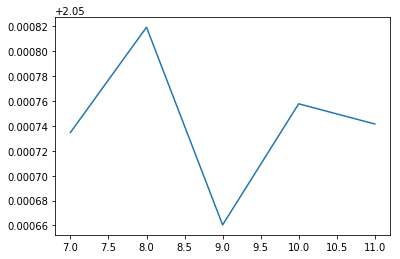

In [13]:
# plot CV误差曲线
test_means = grid_search.cv_results_[ 'mean_test_score' ]
test_stds = grid_search.cv_results_[ 'std_test_score' ]
# train_means = grid_search.cv_results_[ 'mean_train_score' ]
# train_stds = grid_search.cv_results_[ 'std_train_score' ]

x_axis = max_depth_s

plt.plot(x_axis, -test_means)
# plt.errorbar(x_axis, -test_means, yerr=test_stds ,label = ' Test')
# plt.errorbar(x_axis, -train_means, yerr=train_stds,label =  ' Train')

plt.show()

In [14]:
max_depth_1 = list(grid_search.best_params_.values())[0]

### 3.num_leaves

In [15]:
params = {'boosting_type': 'gbdt',
          'objective': 'multiclass',
          'num_class': 33,
          'learning_rate': 0.1,
           'n_estimators':n_estimators_1,
          'max_depth': max_depth_1,
          'subsample': 0.7,
          'bagging_freq': 1,
          'colsample_bytree': 0.7,
          'lambda_l1': 0.4,
          'lambda_l2': 0.5,
          'n_jobs': 4,
          'max_bin': 127 #2^6,原始特征为整数，很少超过100
         }
lg = LGBMClassifier(silent=False,  **params)

num_leaves_s = range(20,70,10) 
tuned_parameters = dict( num_leaves = num_leaves_s)

grid_search = GridSearchCV(lg, n_jobs=4, param_grid=tuned_parameters, cv = kfold, scoring="neg_log_loss", verbose=2, refit = False)
grid_search.fit(X_train , y_clf_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed: 64.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
             error_score='raise-deprecating',
             estimator=LGBMClassifier(bagging_freq=1, boosting_type='gbdt',
                                      class_weight=None, colsample_bytree=0.7,
                                      importance_type='split', lambda_l1=0.4,
                                      lambda_l2=0.5, learning_rate=0.1,
                                      max_bin=127, max_depth=9,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_spli..., n_estimators=228,
                                      n_jobs=4, num_class=33, num_leaves=31,
                                      objective='multiclass', random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      silent=False, subsample=0.7,
                         

In [16]:
# examine the best model
print(-grid_search.best_score_)
print(grid_search.best_params_)

2.050259519517991
{'num_leaves': 30}


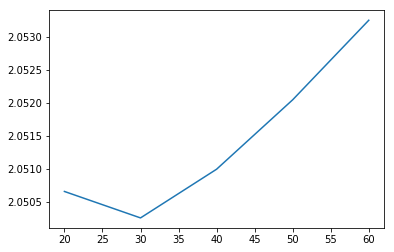

In [17]:
# plot CV误差曲线
test_means = grid_search.cv_results_[ 'mean_test_score' ]
test_stds = grid_search.cv_results_[ 'std_test_score' ]
# train_means = grid_search.cv_results_[ 'mean_train_score' ]
# train_stds = grid_search.cv_results_[ 'std_train_score' ]

x_axis = num_leaves_s

plt.plot(x_axis, -test_means)
#plt.errorbar(x_axis, -test_scores, yerr=test_stds ,label = ' Test')
#plt.errorbar(x_axis, -train_scores, yerr=train_stds,label =  +' Train')

plt.show()

In [18]:
num_leaves_1 = list(grid_search.best_params_.values())[0]

### 4.min_child_samples

In [19]:
params = {'boosting_type': 'gbdt',
          'objective': 'multiclass',
          'num_class': 33,
          'learning_rate': 0.1,
           'n_estimators':n_estimators_1,
          'max_depth': max_depth_1,
          'num_leaves':num_leaves_1,
          'subsample': 0.7,
          'bagging_freq': 1,
          'colsample_bytree': 0.7,
          'lambda_l1': 0.4,
          'lambda_l2': 0.5,
          'n_jobs': 4,
          'max_bin': 127 #2^6,原始特征为整数，很少超过100
         }
lg = LGBMClassifier(silent=False,  **params)

min_child_samples_s = range(60,110,10) 
tuned_parameters = dict( min_child_samples = min_child_samples_s)

grid_search = GridSearchCV(lg, n_jobs=4,  param_grid=tuned_parameters, cv = kfold, scoring="neg_log_loss", verbose=2, refit = False)
grid_search.fit(X_train , y_clf_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed: 61.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
             error_score='raise-deprecating',
             estimator=LGBMClassifier(bagging_freq=1, boosting_type='gbdt',
                                      class_weight=None, colsample_bytree=0.7,
                                      importance_type='split', lambda_l1=0.4,
                                      lambda_l2=0.5, learning_rate=0.1,
                                      max_bin=127, max_depth=9,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_spli...ators=228,
                                      n_jobs=4, num_class=33, num_leaves=30,
                                      objective='multiclass', random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      silent=False, subsample=0.7,
                                  

In [20]:
# examine the best model
print(-grid_search.best_score_)
print(grid_search.best_params_)

2.050078729497037
{'min_child_samples': 60}


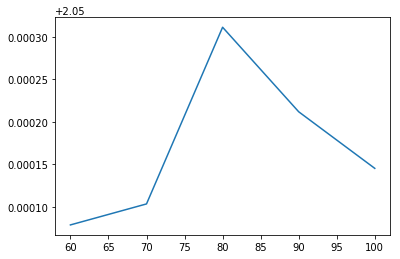

In [21]:
# plot CV误差曲线
test_means = grid_search.cv_results_[ 'mean_test_score' ]
test_stds = grid_search.cv_results_[ 'std_test_score' ]
# train_means = grid_search.cv_results_[ 'mean_train_score' ]
# train_stds = grid_search.cv_results_[ 'std_train_score' ]

x_axis = min_child_samples_s

plt.plot(x_axis, -test_means)
#plt.errorbar(x_axis, -test_scores, yerr=test_stds ,label = ' Test')
#plt.errorbar(x_axis, -train_scores, yerr=train_stds,label =  +' Train')

plt.show()

In [22]:
min_child_samples_1 = list(grid_search.best_params_.values())[0]

### 5.subsample

In [23]:
params = {'boosting_type': 'gbdt',
          'objective': 'multiclass',
          'num_class': 33,
          'learning_rate': 0.1,
           'n_estimators':n_estimators_1,
          'max_depth': max_depth_1,
          'num_leaves':num_leaves_1,
          'min_child_samples':min_child_samples_1,
          'bagging_freq': 1,
          'colsample_bytree': 0.7,
          'lambda_l1': 0.4,
          'lambda_l2': 0.5,
          'n_jobs': 4,
          'max_bin': 127 #2^6,原始特征为整数，很少超过100
         }
lg = LGBMClassifier(silent=False,  **params)

subsample_s = [i/10.0 for i in range(5,11)]
tuned_parameters = dict( subsample = subsample_s)

grid_search = GridSearchCV(lg, n_jobs=4,  param_grid=tuned_parameters, cv = kfold, scoring="neg_log_loss", verbose=2, refit = False)
grid_search.fit(X_train , y_clf_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 70.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
             error_score='raise-deprecating',
             estimator=LGBMClassifier(bagging_freq=1, boosting_type='gbdt',
                                      class_weight=None, colsample_bytree=0.7,
                                      importance_type='split', lambda_l1=0.4,
                                      lambda_l2=0.5, learning_rate=0.1,
                                      max_bin=127, max_depth=9,
                                      min_child_samples=60,
                                      min_child_weight=0.001,
                                      min_spli...tors=228,
                                      n_jobs=4, num_class=33, num_leaves=30,
                                      objective='multiclass', random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      silent=False, subsample=1.0,
                                   

In [24]:
# examine the best model
print(-grid_search.best_score_)
print(grid_search.best_params_)

2.048941460943096
{'subsample': 1.0}


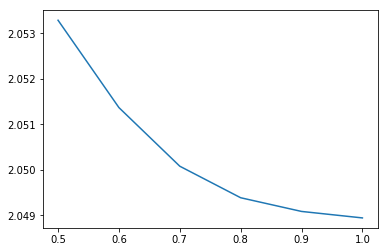

In [25]:
# plot CV误差曲线
test_means = grid_search.cv_results_[ 'mean_test_score' ]
test_stds = grid_search.cv_results_[ 'std_test_score' ]
# train_means = grid_search.cv_results_[ 'mean_train_score' ]
# train_stds = grid_search.cv_results_[ 'std_train_score' ]

x_axis = subsample_s

plt.plot(x_axis, -test_means)
#plt.errorbar(x_axis, -test_scores, yerr=test_stds ,label = ' Test')
#plt.errorbar(x_axis, -train_scores, yerr=train_stds,label =  +' Train')

plt.show()

In [26]:
subsample_1 = list(grid_search.best_params_.values())[0]

### 6.bagging_freq

In [28]:
params = {'boosting_type': 'gbdt',
          'objective': 'multiclass',
          'num_class': 33,
          'learning_rate': 0.1,
           'n_estimators':n_estimators_1,
          'max_depth': max_depth_1,
          'num_leaves':num_leaves_1,
          'min_child_samples':min_child_samples_1,
          'subsample': subsample_1,
          'colsample_bytree': 0.7,
          'lambda_l1': 0.4,
          'lambda_l2': 0.5,
          'n_jobs': 4,
          'max_bin': 127 #2^6,原始特征为整数，很少超过100
         }
lg = LGBMClassifier(silent=False,  **params)

bagging_freq_s = range(1,5)
tuned_parameters = dict( bagging_freq = bagging_freq_s)

grid_search = GridSearchCV(lg, n_jobs=4,  param_grid=tuned_parameters, cv = kfold, scoring="neg_log_loss", verbose=2, refit = False)
grid_search.fit(X_train , y_clf_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed: 46.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
             error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=0.7,
                                      importance_type='split', lambda_l1=0.4,
                                      lambda_l2=0.5, learning_rate=0.1,
                                      max_bin=127, max_depth=9,
                                      min_child_samples=60,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=228,
                                      n_jobs=4, num_class=33, num_leaves=30,
                                      objective='multiclass', random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      silent=False, subsample=1.0,
                                  

In [29]:
# examine the best model
print(-grid_search.best_score_)
print(grid_search.best_params_)

2.048941460943096
{'bagging_freq': 1}


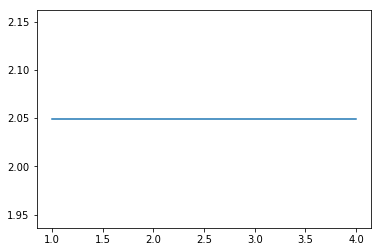

In [30]:
# plot CV误差曲线
test_means = grid_search.cv_results_[ 'mean_test_score' ]
test_stds = grid_search.cv_results_[ 'std_test_score' ]
# train_means = grid_search.cv_results_[ 'mean_train_score' ]
# train_stds = grid_search.cv_results_[ 'std_train_score' ]

x_axis = bagging_freq_s

plt.plot(x_axis, -test_means)
#plt.errorbar(x_axis, -test_scores, yerr=test_stds ,label = ' Test')
#plt.errorbar(x_axis, -train_scores, yerr=train_stds,label =  +' Train')

plt.show()

In [31]:
bagging_freq_1 = list(grid_search.best_params_.values())[0]

### 7.colsample_bytree

In [32]:
params = {'boosting_type': 'gbdt',
          'objective': 'multiclass',
          'num_class': 33,
          'learning_rate': 0.1,
           'n_estimators':n_estimators_1,
          'max_depth': max_depth_1,
          'num_leaves':num_leaves_1,
          'min_child_samples':min_child_samples_1,
          'subsample': subsample_1,
          'bagging_freq': bagging_freq_1,
          'lambda_l1': 0.4,
          'lambda_l2': 0.5,
          'n_jobs': 4,
          'max_bin': 127 #2^6,原始特征为整数，很少超过100
         }
lg = LGBMClassifier(silent=False,  **params)

colsample_bytree_s = [i/10.0 for i in range(5,11)]
tuned_parameters = dict( colsample_bytree = colsample_bytree_s)

grid_search = GridSearchCV(lg, n_jobs=4,  param_grid=tuned_parameters, cv = kfold, scoring="neg_log_loss", verbose=2, refit = False)
grid_search.fit(X_train , y_clf_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 95.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
             error_score='raise-deprecating',
             estimator=LGBMClassifier(bagging_freq=1, boosting_type='gbdt',
                                      class_weight=None, colsample_bytree=1.0,
                                      importance_type='split', lambda_l1=0.4,
                                      lambda_l2=0.5, learning_rate=0.1,
                                      max_bin=127, max_depth=9,
                                      min_child_samples=60,
                                      min_child_weight=0.001,
                                      min_spli...8,
                                      n_jobs=4, num_class=33, num_leaves=30,
                                      objective='multiclass', random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      silent=False, subsample=1.0,
                                      subs

In [33]:
# examine the best model
print(-grid_search.best_score_)
print(grid_search.best_params_)

2.048941460943096
{'colsample_bytree': 0.7}


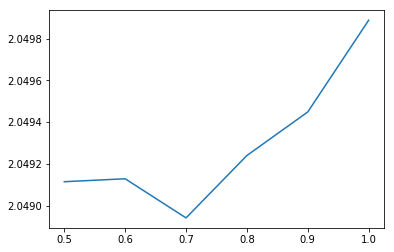

In [34]:
# plot CV误差曲线
test_means = grid_search.cv_results_[ 'mean_test_score' ]
test_stds = grid_search.cv_results_[ 'std_test_score' ]
# train_means = grid_search.cv_results_[ 'mean_train_score' ]
# train_stds = grid_search.cv_results_[ 'std_train_score' ]

x_axis = colsample_bytree_s

plt.plot(x_axis, -test_means)
#plt.errorbar(x_axis, -test_scores, yerr=test_stds ,label = ' Test')
#plt.errorbar(x_axis, -train_scores, yerr=train_stds,label =  +' Train')

plt.show()

In [35]:
colsample_bytree_1 = list(grid_search.best_params_.values())[0]

### 8.lambda_l1

In [45]:
params = {'boosting_type': 'gbdt',
          'objective': 'multiclass',
          'num_class': 33,
          'learning_rate': 0.1,
           'n_estimators':n_estimators_1,
          'max_depth': max_depth_1,
          'num_leaves':num_leaves_1,
          'min_child_samples':min_child_samples_1,
          'subsample': subsample_1,
          'bagging_freq': bagging_freq_1,
          'colsample_bytree': colsample_bytree_1,
          'lambda_l2': 0.5,
          'n_jobs': 4,
          'max_bin': 127 #2^6,原始特征为整数，很少超过100
         }
lg = LGBMClassifier(silent=False,  **params)

lambda_l1_s = [i/10.0 for i in range(7,11)]
tuned_parameters = dict( lambda_l1 = lambda_l1_s)

grid_search = GridSearchCV(lg, n_jobs=4,  param_grid=tuned_parameters, cv = kfold, scoring="neg_log_loss", verbose=2, refit = False)
grid_search.fit(X_train , y_clf_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed: 47.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
             error_score='raise-deprecating',
             estimator=LGBMClassifier(bagging_freq=1, boosting_type='gbdt',
                                      class_weight=None, colsample_bytree=0.7,
                                      importance_type='split', lambda_l2=0.5,
                                      learning_rate=0.1, max_bin=127,
                                      max_depth=9, min_child_samples=60,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=228,
                                      n_jobs=4, num_class=33, num_leaves=30,
                                      objective='multiclass', random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      silent=False, subsample=1.0,
                                      subsample_for_bin=200000,
       

In [46]:
# examine the best model
print(-grid_search.best_score_)
print(grid_search.best_params_)

2.048516808367803
{'lambda_l1': 1.0}


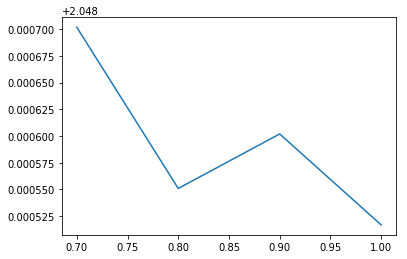

In [47]:
# plot CV误差曲线
test_means = grid_search.cv_results_[ 'mean_test_score' ]
test_stds = grid_search.cv_results_[ 'std_test_score' ]
# train_means = grid_search.cv_results_[ 'mean_train_score' ]
# train_stds = grid_search.cv_results_[ 'std_train_score' ]

x_axis = lambda_l1_s

plt.plot(x_axis, -test_means)
#plt.errorbar(x_axis, -test_scores, yerr=test_stds ,label = ' Test')
#plt.errorbar(x_axis, -train_scores, yerr=train_stds,label =  +' Train')

plt.show()

In [48]:
lambda_l1_1 = list(grid_search.best_params_.values())[0]

### 9.lambda_l2

In [49]:
params = {'boosting_type': 'gbdt',
          'objective': 'multiclass',
          'num_class': 33,
          'learning_rate': 0.1,
           'n_estimators':n_estimators_1,
          'max_depth': max_depth_1,
          'num_leaves':num_leaves_1,
          'min_child_samples':min_child_samples_1,
          'subsample': subsample_1,
          'bagging_freq': bagging_freq_1,
          'colsample_bytree': colsample_bytree_1,
          'lambda_l1': lambda_l1_1,
          'n_jobs': 4,
          'max_bin': 127 #2^6,原始特征为整数，很少超过100
         }
lg = LGBMClassifier(silent=False,  **params)

lambda_l2_s = [i/10.0 for i in range(7,11)]
tuned_parameters = dict( lambda_l2 = lambda_l2_s)

grid_search = GridSearchCV(lg, n_jobs=4,  param_grid=tuned_parameters, cv = kfold, scoring="neg_log_loss", verbose=2, refit = False)
grid_search.fit(X_train , y_clf_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed: 48.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
             error_score='raise-deprecating',
             estimator=LGBMClassifier(bagging_freq=1, boosting_type='gbdt',
                                      class_weight=None, colsample_bytree=0.7,
                                      importance_type='split', lambda_l1=1.0,
                                      learning_rate=0.1, max_bin=127,
                                      max_depth=9, min_child_samples=60,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=228,
                                      n_jobs=4, num_class=33, num_leaves=30,
                                      objective='multiclass', random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      silent=False, subsample=1.0,
                                      subsample_for_bin=200000,
       

In [50]:
# examine the best model
print(-grid_search.best_score_)
print(grid_search.best_params_)

2.047929465709862
{'lambda_l2': 1.0}


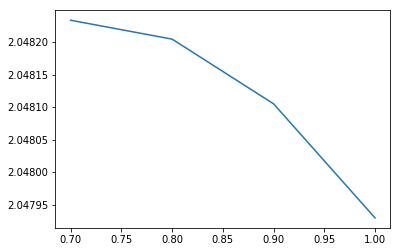

In [51]:
# plot CV误差曲线
test_means = grid_search.cv_results_[ 'mean_test_score' ]
test_stds = grid_search.cv_results_[ 'std_test_score' ]
# train_means = grid_search.cv_results_[ 'mean_train_score' ]
# train_stds = grid_search.cv_results_[ 'std_train_score' ]

x_axis = lambda_l2_s

plt.plot(x_axis, -test_means)
#plt.errorbar(x_axis, -test_scores, yerr=test_stds ,label = ' Test')
#plt.errorbar(x_axis, -train_scores, yerr=train_stds,label =  +' Train')

plt.show()

In [52]:
lambda_l2_1 = list(grid_search.best_params_.values())[0]

### 10.减小学习率，调整n_estimators

In [54]:
# params = {'boosting_type': 'gbdt',
#           'objective': 'multiclass',
#           'num_class': 33,
#           'learning_rate': 0.01,
#            'n_estimators':n_estimators_1,
#           'max_depth': max_depth_1,
#           'num_leaves':num_leaves_1,
#           'min_child_samples':min_child_samples_1,
#           'subsample': subsample_1,
#           'bagging_freq': bagging_freq_1,
#           'colsample_bytree': colsample_bytree_1,
#           'lambda_l1': lambda_l1_1,
#           'lambda_l2': lambda_l2_1,
#           'n_jobs': 4,
#           'max_bin': 127 #2^6,原始特征为整数，很少超过100
#          }
# n_estimators_2 = get_n_estimators(params , X_train , y_clf_train)

f:\software\python\lib\site-packages\lightgbm\engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


best n_estimators: 1
best cv score: 0.5918129991784107


In [23]:
params = {'boosting_type': 'gbdt',
          'objective': 'multiclass',
          'num_class': 33,
          'learning_rate': 0.1,
           'n_estimators':n_estimators_1,
          'max_depth': 9,
          'num_leaves':30,
          'min_child_samples':60,
          'subsample': 1.0,
          'bagging_freq': 1,
          'colsample_bytree': 0.7,
          'lambda_l1': 1,
          'lambda_l2': 1,
          'n_jobs': 8,
          'max_bin': 127 #2^6,原始特征为整数，很少超过100
         }
n_estimators_2 = get_n_estimators(params , X_train , y_clf_train)

f:\software\python\lib\site-packages\lightgbm\engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


best n_estimators: 197
best cv score: 2.0467543608373093


### 11.用所有训练数据，采用最佳参数重新训练模型

In [55]:
# params = {'boosting_type': 'gbdt',
#           'objective': 'multiclass',
#           'num_class': 33,
#           'learning_rate': 0.1,
#            'n_estimators':168,
#           'max_depth': max_depth_1,
#           'num_leaves':num_leaves_1,
#           'min_child_samples':min_child_samples_1,
#           'subsample': subsample_1,
#           'bagging_freq': bagging_freq_1,
#           'colsample_bytree': colsample_bytree_1,
#           'lambda_l1': lambda_l1_1,
#           'lambda_l2': lambda_l2_1,
#           'n_jobs': 4,
#           'max_bin': 127 #2^6,原始特征为整数，很少超过100
#          }
# lg = LGBMClassifier(silent=False,  **params)
# lg.fit(X_train, y_clf_train)

LGBMClassifier(bagging_freq=1, boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.7, importance_type='split', lambda_l1=1.0,
               lambda_l2=1.0, learning_rate=0.1, max_bin=127, max_depth=9,
               min_child_samples=60, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=168, n_jobs=4, num_class=33, num_leaves=30,
               objective='multiclass', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=False, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [24]:
params = {'boosting_type': 'gbdt',
          'objective': 'multiclass',
          'num_class': 33,
          'learning_rate': 0.1,
           'n_estimators':n_estimators_2,
          'max_depth': 9,
          'num_leaves':30,
          'min_child_samples':60,
          'subsample': 1.0,
          'bagging_freq': 1,
          'colsample_bytree': 0.7,
          'lambda_l1': 1,
          'lambda_l2': 1,
          'n_jobs': 8,
          'max_bin': 127 #2^6,原始特征为整数，很少超过100
         }
lg = LGBMClassifier(silent=False,  **params)
lg.fit(X_train, y_clf_train)

LGBMClassifier(bagging_freq=1, boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.7, importance_type='split', lambda_l1=1,
               lambda_l2=1, learning_rate=0.1, max_bin=127, max_depth=9,
               min_child_samples=60, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=197, n_jobs=8, num_class=33, num_leaves=30,
               objective='multiclass', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=False, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

## 保存模型

In [25]:
import pickle

pickle.dump(lg, open("lgb_gbdt.pkl", 'wb'))

In [26]:
df = pd.DataFrame({"columns":list(feat_names), "importance":list(lg.feature_importances_.T)})
df = df.sort_values(by=['importance'],ascending=False)

In [27]:
df

,columns,importance
16,early_repay_days_std,6962
5,principal,6717
15,early_repay_days_mean,6419
1,listing_id,6283
13,early_repay_days_median,5855
12,early_repay_days_max,5405
7,age,5002
62,behaviro_type3,4828
59,sum,4444
14,early_repay_days_sum,4397
